# Velocity Testing
Now we're importing velocity information from our simulations into `synthesizAR`. This means we have to correctly map the field-aligned velocity onto the $xyz$ grid of the active region.

In [1]:
import os
import sys
import subprocess

import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn
import astropy.units as u
import h5py
import sunpy.map

import synthesizAR
from synthesizAR.model_ext import EbtelInterface,PowerLawScaledWaitingTimes
from synthesizAR.instruments import InstrumentHinodeEIS

%matplotlib inline

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
ar_root = '/data/datadrive2/ar_viz/velocity_testing/'

## Field

In [3]:
crop = (u.Quantity([-400,-140]*u.arcsec),u.Quantity([320,540]*u.arcsec))
resample = u.Quantity([100,100]*u.pixel)
field = synthesizAR.Skeleton('/home/wtb2/sunpy/data/hmi_m_45s_2010_06_19_03_06_00_tai_magnetogram.fits',
                             crop=crop,resample=resample)
zshape=50
zrange=u.Quantity([0.,150.]*u.arcsec)
field.extrapolate_field(zshape,zrange)

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


True


/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/numba/decorators.py:24: DeprecationWarning: autojit is deprecated, use jit instead which now performs the same functionality
  "the same functionality", DeprecationWarning)
yt : [INFO     ] 2016-12-20 18:58:51,361 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-12-20 18:58:51,362 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2016-12-20 18:58:51,363 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2016-12-20 18:58:51,364 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2016-12-20 18:58:51,365 Parameters: cosmological_simulation   = 0.0


In [4]:
field.extract_streamlines(100,loop_length_range=[1e+9,1e+11]*u.cm)

yt : [INFO     ] 2016-12-20 18:58:55,965 AMRKDTree rebuilt, Final Volume: 2.874169e+30
Streamlining: 100%|██████████| 100/100 [00:00<00:00, 345.57it/s]
yt : [INFO     ] 2016-12-20 18:58:57,741 AMRKDTree rebuilt, Final Volume: 2.874169e+30
Streamlining: 100%|██████████| 25/25 [00:00<00:00, 298.22it/s]
yt : [INFO     ] 2016-12-20 18:58:58,317 AMRKDTree rebuilt, Final Volume: 2.874169e+30
Streamlining: 100%|██████████| 5/5 [00:00<00:00, 175.55it/s]
yt : [INFO     ] 2016-12-20 18:58:58,574 AMRKDTree rebuilt, Final Volume: 2.874169e+30
Streamlining: 100%|██████████| 1/1 [00:00<00:00, 97.28it/s]


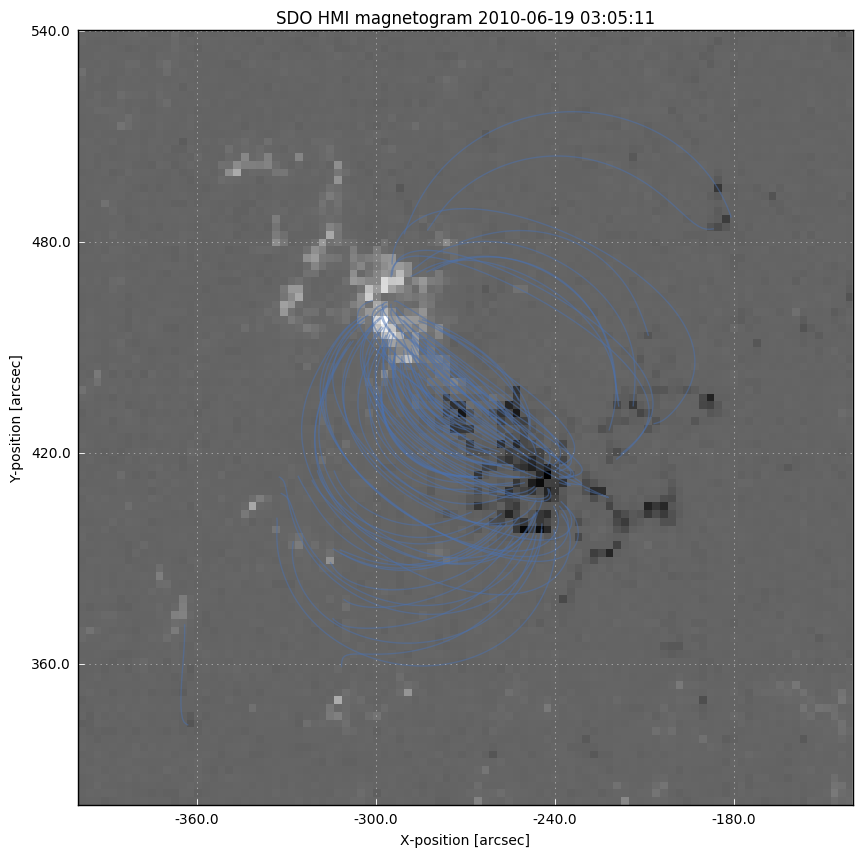

In [5]:
field.peek(alpha=0.5)

In [6]:
field.make_loops()

## Simulation

In [7]:
heating_options = {
    'duration':200.0,
    'duration_rise':100.0,
    'duration_decay':100.0,
    'average_waiting_time':1000.0,
    'stress_level':0.3,
    'alpha':-2.5,
    'delta_power_law_bounds':100,
    'waiting_time_scaling':1.0,
}
heating_model = PowerLawScaledWaitingTimes(heating_options)

In [8]:
ih = synthesizAR.util.InputHandler(os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/config/ebtel.example.cfg.xml'))
base_config = ih.lookup_vars()
base_config['c1_cond0'] = 6.0
base_config['use_adaptive_solver'] = True
base_config['tau'] = 1.0
base_config['adaptive_solver_error'] = 1e-12
base_config['adaptive_solver_safety'] = 0.01
base_config['total_time'] = 5000.0
ebtel_plug = EbtelInterface(base_config,heating_model)
field.configure_loop_simulations(ebtel_plug,
                                 parent_config_dir=os.path.join(ar_root,'hydro_config'),
                                 parent_results_dir=os.path.join(ar_root,'hydro_results'))

Power-law constrainer reached max # of tries, using best guess with error = 0.001977
Power-law constrainer reached max # of tries, using best guess with error = 0.001142
Power-law constrainer reached max # of tries, using best guess with error = 0.001726
Power-law constrainer reached max # of tries, using best guess with error = 0.001832
Power-law constrainer reached max # of tries, using best guess with error = 0.001256
Power-law constrainer reached max # of tries, using best guess with error = 0.001629
Power-law constrainer reached max # of tries, using best guess with error = 0.001258


In [9]:
for loop in field.loops:
    subprocess.call([os.path.join(os.environ['RESEARCH_DIR'],'ebtelPlusPlus/bin/ebtel++.run'),
                     '-c',loop.hydro_configuration['config_filename']])

In [10]:
field.load_loop_simulations(ebtel_plug,savefile=os.path.join(ar_root,'loop_parameters.h5'))

Save the field.

In [11]:
field.save(savedir=os.path.join(ar_root,'checkpoint'))

Restore the field!

In [3]:
field = synthesizAR.Skeleton.restore(os.path.join(ar_root,'checkpoint'))

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-01-05 14:09:34,686 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-01-05 14:09:34,688 Parameters: domain_dimensions         = [96 96 46]
yt : [INFO     ] 2017-01-05 14:09:34,690 Parameters: domain_left_edge          = [ -2.89511786e+10   2.37893407e+10   4.40182588e+08]
yt : [INFO     ] 2017-01-05 14:09:34,691 Parameters: domain_right_edge         = [ -1.06601257e+10   3.93100982e+10   1.05643821e+10]
yt : [INFO     ] 2017-01-05 14:09:34,692 Parameters: cosmological_simulation   = 0.0


## Velocity Measurements
Let's take a look at some of the $(x,y,z)$ velocity components to make sure we did the calculation for those correctly.

In [4]:
loop = field.loops[60]

In [5]:
with h5py.File(loop.parameters_savefile,'r') as hf:
    velocity_xyz = np.array(hf['/{}/velocity_xyz'.format(loop.name)])

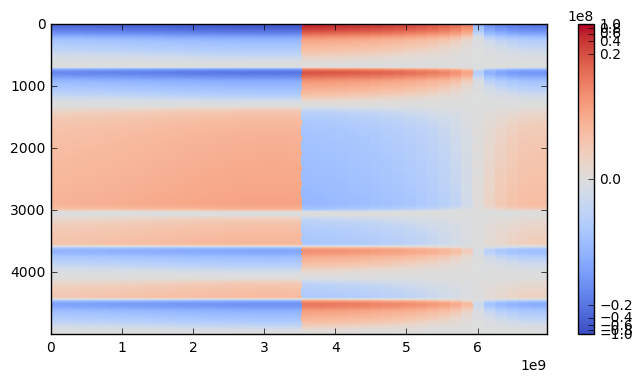

In [6]:
time_mesh,space_mesh = np.meshgrid(loop.field_aligned_coordinate,loop.time[:])
fig = plt.figure(figsize=(8,4))
ax = fig.gca()
im = ax.pcolormesh(time_mesh.value,space_mesh.value,velocity_xyz[:,:,0],
                   norm=matplotlib.colors.SymLogNorm(1e5,vmin=-1e8,vmax=1e8),
                   #cmap='RdBu'
                   cmap=matplotlib.colors.ListedColormap(seaborn.color_palette('coolwarm',n_colors=1000))
                  )
fig.colorbar(im)
ax.set_xlim([loop.field_aligned_coordinate[0].value,loop.field_aligned_coordinate[-1].value])
ax.set_ylim([loop.time[0].value,loop.time[-1].value])
ax.invert_yaxis()

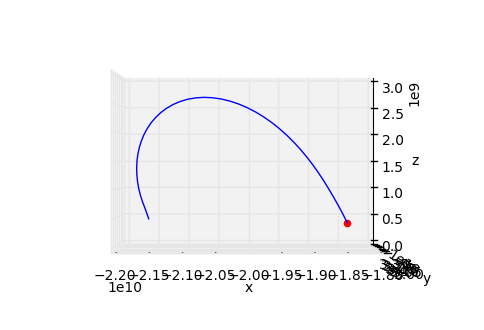

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(loop.coordinates[:,0][0],loop.coordinates[:,1][0],loop.coordinates[:,2][0],'o',color='r')
ax.plot(loop.coordinates[:,0],loop.coordinates[:,1],loop.coordinates[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(0,270)

## Velocity Binning
Now how do we treat this quantity in our 3D cartesian grid? 

In [251]:
channel_wvl = np.arange(90,110,0.1)

In [282]:
lambda0a,lambda0b = 99.1,101.9
sigma_wvla,sigma_wvlb = 1.2,1.9
intensity0a,intensity0b = 10.0,7.0

In [283]:
specific_intensity = np.zeros(len(channel_wvl))
specific_intensity_a = intensity0a/np.sqrt(np.pi*sigma_wvla**2)*np.exp(-((channel_wvl - lambda0a)**2)/(sigma_wvla**2))
specific_intensity_b = intensity0b/np.sqrt(np.pi*sigma_wvlb**2)*np.exp(-((channel_wvl - lambda0b)**2)/(sigma_wvlb**2))
specific_intensity += specific_intensity_a + specific_intensity_b

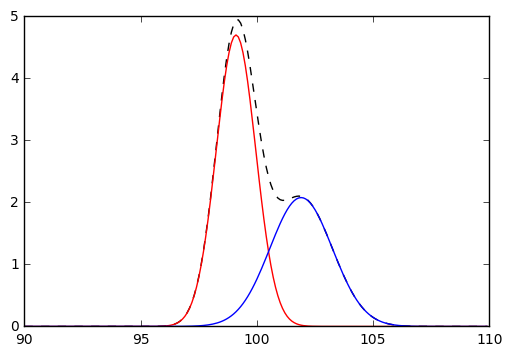

In [284]:
plt.plot(channel_wvl,specific_intensity,'--k')
plt.plot(channel_wvl,specific_intensity_a,'r')
plt.plot(channel_wvl,specific_intensity_b,'b')

To calculate the line intensity, we'll use the equation
$$
I_{\lambda} = \frac{I_0}{\sqrt{\pi\sigma^2}}\exp\left(-\frac{(\lambda - \lambda_0 - \Delta\lambda)^2}{\sigma^2}\right),
$$
where $\sigma^2 = \sigma_{th}^2 + \sigma_{ins}^2$, $\Delta\lambda=\lambda_0 v_{LOS}/c$ and $\sigma_{th}=v_{th}\lambda_0/c$. $v_{th}=\sqrt{2kT/\mu m_p}$ is the ion thermal velocity.

We have $I_0$ as a function of pixel coordinate. So we also need $T$ and $v_{LOS}$ as a function of pixel coordinate. For both $T$ and $v_{LOS}$, we compute the average in each 3D bin, meaning we need to divide by the number of samples per bin.

We'll carry out this test at a single timestep $\tau$.

In [22]:
eis = InstrumentHinodeEIS('/home/wtb2/Documents/Forward_Model/instruments/Hinode_EIS/',[0,4900]*u.s)

In [23]:
eis.make_detector_array(field)

In [24]:
observer = synthesizAR.Observer(field,[eis],ds=field._convert_angle_to_length(0.3*u.arcsec))

/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py:300: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  warnings.warn(RuntimeWarning(_iermess[ier][0]))
/opt/anaconda3/envs/synthesizar/lib/python3.5/site-packages/scipy/interpolate/fitpack.py

In [25]:
bins_z,bin_range_z = observer._make_z_bins(eis)

In [26]:
counts,edges = np.histogramdd(observer.total_coordinates.value,
                             bins=[eis.bins.x,eis.bins.y,bins_z],
                             range=[eis.bin_range.x,eis.bin_range.y,bin_range_z])

Need to concatenate all of the LOS velocities into one list (for a given timestep).

In [58]:
los_velocities = []
for i,loop in enumerate(field.loops):
    t_index = np.where(loop.time.value>4500)[0][0]
    with h5py.File(loop.parameters_savefile,'r') as hf:
        vxyz = np.array(hf['/{}/velocity_xyz'.format(loop.name)][t_index,:,:])
    nots = scipy.interpolate.splrep(loop.field_aligned_coordinate.value,np.dot(vxyz,(0,0,-1)))
    los_velocities += list(scipy.interpolate.splev(observer._interpolated_loop_coordinates[i],nots))

In [59]:
velocity_average,edges = np.histogramdd(observer.total_coordinates.value,
                             bins=[eis.bins.x,eis.bins.y,bins_z],
                             range=[eis.bin_range.x,eis.bin_range.y,bin_range_z],
                                       weights=los_velocities)

In [60]:
velocity_average = velocity_average/np.where(counts==0,1,counts)

In [61]:
vel_projection = np.dot(velocity_average,np.diff(edges[2])).T/np.sum(np.diff(edges[2]))

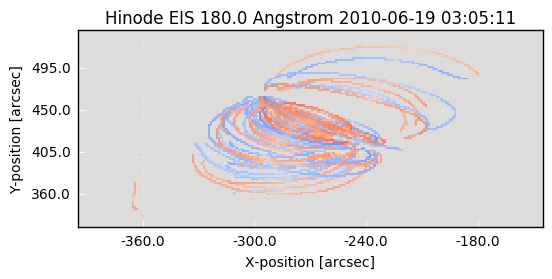

In [62]:
sunpy.map.Map(vel_projection,eis.make_fits_header(field,eis.channels[0])).plot(
    norm=matplotlib.colors.SymLogNorm(10,vmin=-1e8,vmax=1e8),
    cmap=matplotlib.colors.ListedColormap(seaborn.color_palette('coolwarm',n_colors=1000))
)

Do we do the same for the temperature? The problem here then is that we can't distinguish between individual spectral lines, only channels, by this step. 

In [68]:
with h5py.File('/data/datadrive2/ar_viz/velocity_testing/loop_parameters.h5','r') as hf:
    for grp in hf:
        if grp=='loop30':
            for ds in hf['{}'.format(grp)]:
                print(ds)

density
temperature
velocity
velocity_xyz


In [8]:
import astropy.io

In [9]:
eis_fits = astropy.io.fits.open('/data/datadrive1/ssw_data/hinode_eis/eis_l0_20160102_032525.fits.gz')

In [10]:
from sunpy.io.fits import get_header

In [13]:
get_header(eis_fits)[1]

FileHeader([('XTENSION', 'BINTABLE'),
            ('BITPIX', 8),
            ('NAXIS', 2),
            ('NAXIS1', 852053),
            ('NAXIS2', 60),
            ('PCOUNT', 0),
            ('GCOUNT', 1),
            ('TFIELDS', 46),
            ('DATE', '2016-01-12'),
            ('ORIGIN', 'ISAS'),
            ('DATA_LEV', 0),
            ('DATE_RF0', '2016-01-12T20:45:24.096'),
            ('ORIG_RF0', 'ISAS'),
            ('VER_RF0', 'EIS_Lev0_Reformatter $Revision: 391 $'),
            ('DATE_RF1', ''),
            ('ORIG_RF1', ''),
            ('VER_RF1', ''),
            ('TELESCOP', 'Hinode'),
            ('INSTRUME', 'EIS'),
            ('LONGSTRN', 'OGIP 1.0'),
            ('TARGET', 'Active Region'),
            ('NOAA_NUM', 0),
            ('SCI_OBJ', 'AR'),
            ('OBS_DEC', 'HPW021VEL120x512v1_b'),
            ('JOIN_SB', 'E'),
            ('OBS_NUM', 1),
            ('JOP_ID', 0),
            ('RAST_ACR', 'HPW021VEL120x512v1_b'),
            ('STUD_ACR', 'HPW021VEL

In [14]:
from sunpy.map import M

In [15]:
MapMeta(get_header(eis_fits)[1])

MapMeta([('xtension', 'BINTABLE'),
         ('bitpix', 8),
         ('naxis', 2),
         ('naxis1', 852053),
         ('naxis2', 60),
         ('pcount', 0),
         ('gcount', 1),
         ('tfields', 46),
         ('date', '2016-01-12'),
         ('origin', 'ISAS'),
         ('data_lev', 0),
         ('date_rf0', '2016-01-12T20:45:24.096'),
         ('orig_rf0', 'ISAS'),
         ('ver_rf0', 'EIS_Lev0_Reformatter $Revision: 391 $'),
         ('date_rf1', ''),
         ('orig_rf1', ''),
         ('ver_rf1', ''),
         ('telescop', 'Hinode'),
         ('instrume', 'EIS'),
         ('longstrn', 'OGIP 1.0'),
         ('target', 'Active Region'),
         ('noaa_num', 0),
         ('sci_obj', 'AR'),
         ('obs_dec', 'HPW021VEL120x512v1_b'),
         ('join_sb', 'E'),
         ('obs_num', 1),
         ('jop_id', 0),
         ('rast_acr', 'HPW021VEL120x512v1_b'),
         ('stud_acr', 'HPW021VEL120x512v1_b'),
         ('ll_acr', 'HPW_AR_HOTv3'),
         ('ll_id', 218),
         (